# COMP0036: Beat the Bookie

### Table of Contents

1. [Introduction](#1-Introduction)

2. [Data Import](#2-Data-Import)

3. [Data Transformation & Exploration](#3-Data-Transformation-&-Exploration)

4. [Methodology Overview](#4-Methodology-Overview)

5. [Model Training & Validation](#5-Model-Training-&-Validation) 

6. [Results](#6-Results)

7. [Final Predictions on Test Set](#7-Final-Predictions-on-Test-Set)

### 1. Introduction

### 2. Data Import

In [1]:
import pandas as pd

# Configure Pandas display settings for better readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Load dataset
df = pd.read_csv('../data/epl-training.csv')

# Show the first few rows
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


### 3. Data Transformation & Exploration

#### 3.1. Data Cleaning

In [2]:
# Define constants
N_SEASONS = 25
MATCHES_PER_SEASON = 380
EXPECTED_LENGTH = N_SEASONS * MATCHES_PER_SEASON

# Check the initial length against the expected length
print(f"Length of DataFrame before cleaning: {len(df)}")
print(f"This is {len(df) - EXPECTED_LENGTH} more than the expected length of {EXPECTED_LENGTH}.")

# Remove rows that are completely empty
df.dropna(how="all", inplace=True)

# Check for duplicates in the first three columns
duplicates = df.iloc[:, :3].duplicated()

if duplicates.any():
    # Get indices of duplicate rows
    duplicate_indices = duplicates[duplicates].index.tolist()
    print(f"Duplicate rows found at indices: {duplicate_indices}")
    print(f"Total duplicates: {len(duplicate_indices)}")

    # Remove those duplicates
    df.drop(index=duplicate_indices, inplace=True)
    print(f"Duplicate rows removed. New length: {len(df)}")
else:
    print("No duplicates found in the first three columns.")

# Print final info
print(f"Final length of the cleaned DataFrame: {len(df)}")


Length of DataFrame before cleaning: 9221
This is -279 more than the expected length of 9500.
Duplicate rows found at indices: [8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940]
Total duplicates: 100
Duplicate rows removed. New length: 9120
Final length of the cleaned DataFrame: 9120


#### 3.2. Web Scraping
```py
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_market_val(year_start, year_end):
    """
    Scrapes Transfermarkt market value data for the Premier League from season year_start 
    up to (but not including) year_end. Saves the final combined data to a CSV file.
    """

    # Fake user agent to avoid 403 Forbidden errors
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/91.0.4472.124 Safari/537.36"
        )
    }

    combined_df = pd.DataFrame()

    # Loop through each season in the specified range
    for year in range(year_start, year_end):
        data_list = []
        print(f"Processing season: {year}")

        # Build the Transfermarkt URL for the given season
        url = f"https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id={year}#google_vignette"
        
        # Send GET request
        response = requests.get(url, headers=headers)
        print(f"Status code: {response.status_code}")

        # Parse the HTML using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locate the table with class 'items'
        table = soup.find('table', class_='items')
        rows = table.find('tbody').find_all('tr')

        # Extract the desired data from each row
        for row in rows:
            columns = row.find_all('td')
            row_data = {
                'Year': year,
                'Club': columns[1].text.strip(),
                'TMV': columns[6].text.strip()[1:],  # Remove the currency symbol (e.g., '£')
            }
            data_list.append(row_data)

        # Create a DataFrame for the current season
        df = pd.DataFrame(data_list)

        # Remove rows that are entirely empty
        df = df[~df.apply(lambda row: row.astype(str).str.strip().eq('').all(), axis=1)]

        # Concatenate with the main DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

        # Sleep to avoid hitting the server too frequently
        time.sleep(5)

    # Save the final DataFrame to a CSV file
    combined_df.to_csv('Engineered Data/Final Data/marketval.csv', index=False)
    print("Data saved to 'Engineered Data/Final Data/marketval.csv'.")

# Example usage
get_market_val(2000, 2025)

```

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_premier_league_results_dynamic():
    """
    Scrapes all Premier League match results and returns them as a DataFrame.
    """

    # Set up Selenium WebDriver
    driver = webdriver.Chrome()
    driver.get("https://www.premierleague.com/results")

    # Handle the cookie banner
    try:
        cookie_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))
        )
        cookie_button.click()
        print("Cookie banner dismissed.")
    except Exception as e:
        print("No cookie banner found or failed to dismiss it.")

    # Handle the ad pop-up
    try:
        ad_close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "advertClose"))
        )
        ad_close_button.click()
        print("Ad pop-up closed.")
    except Exception as e:
        print("No ad pop-up found or failed to close it.")

    # Scroll to the bottom to load all data
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    print("All content loaded.")

    # Get the page source
    page_source = driver.page_source
    driver.quit()

    # Parse with BeautifulSoup
    soup = BeautifulSoup(page_source, 'html.parser')
    fixtures_section = soup.find('section', class_='fixtures')
    if not fixtures_section:
        print("No fixtures section found.")
        return pd.DataFrame()

    # Extract match data
    match_data = []
    date_containers = fixtures_section.find_all('div', class_='fixtures__date-container')
    for date_container in date_containers:
        date = date_container.find('time', class_='fixtures__date--long').get('datetime')
        match_list = date_container.find('div', class_='fixtures__matches-list').find_all('li', class_='match-fixture')
        for match in match_list:
            try:
                home_team = match['data-home']
                away_team = match['data-away']
                score = match.find('span', class_='match-fixture__score').text.strip()
                home_goals, away_goals = map(int, score.split('-'))
                ftr = "H" if home_goals > away_goals else "A" if home_goals < away_goals else "D"
                match_data.append({
                    'Date': date,
                    'HomeTeam': home_team,
                    'AwayTeam': away_team,
                    'FTHG': home_goals,
                    'FTAG': away_goals,
                    'FTR': ftr
                })
            except Exception as e:
                print(f"Error processing match: {e}")
                continue

    # Return the scraped data as a DataFrame
    return pd.DataFrame(match_data)

# Call the scraping function and get the scraped data as a DataFrame
scraped_df = scrape_premier_league_results_dynamic()
print("Scraped Data:")
scraped_df.head()


Cookie banner dismissed.
Ad pop-up closed.
All content loaded.
Scraped Data:


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,Wednesday 1 January 2025,Brentford,Arsenal,1,3,A
1,Monday 30 December 2024,Aston Villa,Brighton,2,2,D
2,Monday 30 December 2024,Ipswich,Chelsea,2,0,H
3,Monday 30 December 2024,Man Utd,Newcastle,0,2,A
4,Sunday 29 December 2024,Leicester,Man City,0,2,A


In [4]:
# Ensure the scraped DataFrame has the same columns as 'df'
# Define the expected column structure (same as df's structure)
columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
           'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

# Reverse the scraped DataFrame so older matches appear first
scraped_df = scraped_df[::-1].reset_index(drop=True)

# Convert the Date column to the desired format: DD/MM/YYYY
scraped_df['Date'] = pd.to_datetime(scraped_df['Date'], format='%A %d %B %Y').dt.strftime('%d/%m/%Y')

# Replace team names in HomeTeam and AwayTeam columns
scraped_df['HomeTeam'] = scraped_df['HomeTeam'].replace({'Spurs': 'Tottenham', 'Man Utd': 'Man United'})
scraped_df['AwayTeam'] = scraped_df['AwayTeam'].replace({'Spurs': 'Tottenham', 'Man Utd': 'Man United'})

# Add missing columns to the scraped DataFrame
for col in columns:
    if col not in scraped_df.columns:
        scraped_df[col] = None

# Reorder the columns in the scraped DataFrame to match 'df'
scraped_df = scraped_df[columns]

# Append the scraped data to the existing DataFrame
df = pd.concat([df, scraped_df], ignore_index=True)



/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/1811498568.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, scraped_df], ignore_index=True)


#### 3.3. Exploring Scraped Data

##### 3.3.1. 14-Day Match Density and Match Attendance

In [5]:
import pandas as pd
from datetime import timedelta

def load_and_prepare_data():
    """
    Load, tag, and combine match data from multiple sources.
    Returns the combined DataFrame.
    """
    # Load data scraping CSV files
    EPL_S = pd.read_csv('../scraped-data/combined-epl.csv')
    FA_S = pd.read_csv('../scraped-data/combined-fa-e.csv')
    EFL_S = pd.read_csv('../scraped-data/combined-efl-e.csv')
    UCL_S = pd.read_csv('../scraped-data/combined-ucl-e.csv')
    UEL_S = pd.read_csv('../scraped-data/combined-uel-e.csv')

    # Tag each DataFrame to identify its source
    EPL_S.insert(0, 'df name', 'EPL')
    FA_S.insert(0, 'df name', 'FA')
    EFL_S.insert(0, 'df name', 'EFL')
    UCL_S.insert(0, 'df name', 'UCL')
    UEL_S.insert(0, 'df name', 'UEL')

    # Combine all DataFrames into one
    combined = pd.concat([EPL_S, FA_S, EFL_S, UCL_S, UEL_S], ignore_index=True)

    # Convert the 'Date' columns to datetime
    combined['Date'] = pd.to_datetime(combined['Date'], format='%d/%m/%Y')

    return combined

def calculate_matches(team, match_date, combined):
    """
    Count matches for a given team in the prior 14 days.
    """
    start_date = match_date - timedelta(days=14)
    matches = combined.loc[
        (
            (combined['HomeTeam'] == team) |
            (combined['AwayTeam'] == team)
        ) &
        (combined['Date'] >= start_date) &
        (combined['Date'] < match_date)
    ]
    return len(matches)

def calculate_14_day_density(df, combined):
    """
    Calculate 14-day match density for home and away teams and merge results into the main DataFrame.
    """
    # Sort the combined DataFrame by date and home team
    combined.sort_values(['Date', 'HomeTeam'], ascending=[True, True], inplace=True)

    # Filter EPL rows and make a copy to avoid SettingWithCopyWarning
    combined_epl = combined.loc[combined['df name'] == 'EPL'].copy()

    # Calculate 14-day match density for home and away teams
    combined_epl['H14'] = combined_epl.apply(
        lambda row: calculate_matches(row['HomeTeam'], row['Date'], combined), axis=1
    )
    combined_epl['A14'] = combined_epl.apply(
        lambda row: calculate_matches(row['AwayTeam'], row['Date'], combined), axis=1
    )

    # Merge H14, A14, and Attendance columns into the main DataFrame
    df = df.merge(
        combined_epl[['Date', 'HomeTeam', 'AwayTeam', 'H14', 'A14', 'Attendance']],
        on=['Date', 'HomeTeam', 'AwayTeam'],
        how='left'
    )

    return df

# Main preprocessing workflow
# Step 1: Load the combined data
combined = load_and_prepare_data()

# Step 2: Convert the 'Date' column in df to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Step 3: Calculate match density and merge results
df = calculate_14_day_density(df, combined)

# Step 4: Convert the 'Date' column back to DD/MM/YYYY format
df['Date'] = df['Date'].dt.strftime('%d/%m/%Y')

# Preview the first few rows
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043"
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914"
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624"
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223"
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010"


##### 3.3.2. Referee Strictness

In [6]:
import pandas as pd

def calculate_referee_strictness(df):
    """
    Standardizes referee names, applies corrections, calculates referee strictness,
    and updates the DataFrame with a 'Strictness' column.
    """
    # Function to standardize referee names based on index ranges
    def standardize_names(index, name):
        if index <= 379:
            parts = name.split()
            return f"{parts[0][0]} {parts[1]}" if len(parts) > 1 else name
        elif index <= 549:
            parts = name.replace('.', '').split()
            return f"{parts[0][0]} {parts[-1]}" if len(parts) > 1 else name
        elif index <= 759:
            parts = name.replace(',', '').replace('.', '').split()
            return f"{parts[1][0]} {parts[0]}" if len(parts) > 1 else name
        elif index >= 1855 and index <= 1863:
            parts = name.split()
            return f"{parts[0][-1]} {parts[1]}" if len(parts) > 1 else name
        else:
            return name

    # Apply the StandardNames function to each row
    df['Referee'] = df.apply(lambda row: standardize_names(row.name, row['Referee']), axis=1)

    # Apply corrections to the 'Referee' column
    name_corrections = {
        "D Gallaghe": "D Gallagher",
        "D Gallagh": "D Gallagher"
    }
    df['Referee'] = df['Referee'].apply(lambda name: name_corrections.get(name, name))

    # Get unique refs and initialize dictionaries
    refs = df['Referee'].unique()
    Y = {ref: 0 for ref in refs}
    R = {ref: 0 for ref in refs}
    MatchCount = {ref: 0 for ref in refs}
    strictness = {}

    # Loop over DataFrame rows to count yellow/red cards and appearances
    for _, row in df.iterrows():
        ref = row['Referee']
        if pd.notna(ref):
            Y[ref] += row['AY'] + row['HY']
            R[ref] += row['AY'] + row['HY']  # Same calculation as Y, possibly intentional
            MatchCount[ref] += 1

    # Compute "strictness" based on total cards and matches
    for ref in refs:
        if MatchCount[ref] > 0:
            strictness[ref] = (Y[ref] + 3 * R[ref]) / MatchCount[ref]
        else:
            strictness[ref] = 0

    # Add a 'Strictness' column to the DataFrame
    df['Strictness'] = df['Referee'].map(strictness)

    return df

# Function call
df = calculate_referee_strictness(df)

# Preview the updated DataFrame
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236


##### 3.3.3. Standings

In [7]:
from tqdm import tqdm

from tqdm import tqdm
import numpy as np

def calculate_standings(df):
    """
    Calculates standings, including cumulative points (Hpts, Apts),
    season, and round information for the given DataFrame.
    Handles cases where FTR is missing for test data.
    """

    # Enable tqdm for Pandas apply operations
    tqdm.pandas()

    # Convert FTR to winner name or 'Draw' (for rows where FTR is not NaN)
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['Winner'] = df.apply(
            lambda row: row['HomeTeam'] if row['FTR'] == 'H' 
                        else ('Draw' if row['FTR'] == 'D' else row['AwayTeam']),
            axis=1
        )
    else:
        df['Winner'] = np.nan  # Set to NaN if FTR is missing

    # Assign 'Season' based on row index (380 matches per season)
    df['Season'] = df.index // 380
    df['Season'] = df['Season'].apply(lambda i: 2000 + i)  # e.g., 0 -> 2000, 1 -> 2001, etc.

    # Assign 'Round' values (there are 38 rounds in a 380-match season)
    roundindex = (df.index - 10) // 10 + 1
    df['Round'] = (roundindex % 38) + 1

    # Recursive function to calculate cumulative points (only for rows with FTR)
    def get_pts(team, season, current_round):
        """
        Returns the points accumulated by 'team' up to (and including) 'current_round'
        in 'season'. Works only if FTR is present.
        """
        if current_round == 1 or 'Winner' not in df.columns:
            return 0

        # Filter for the previous round in the same season
        prev_round_data = df[
            (df['Season'] == season) & 
            (df['Round'] == current_round - 1)
        ]

        # Points based on Winner
        homewin = (prev_round_data['HomeTeam'] == team) & (prev_round_data['Winner'] == team)
        awaywin = (prev_round_data['AwayTeam'] == team) & (prev_round_data['Winner'] == team)
        draw = (
            ((prev_round_data['HomeTeam'] == team) | (prev_round_data['AwayTeam'] == team)) 
            & (prev_round_data['Winner'] == 'Draw')
        )

        # Points in the previous round
        if homewin.any() or awaywin.any():
            roundpts = 3
        elif draw.any():
            roundpts = 1
        else:
            roundpts = 0

        # Recursively add the points from earlier rounds
        return roundpts + get_pts(team, season, current_round - 1)

    # Calculate home and away teams' cumulative points (only where FTR is present)
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['Hpts'] = df.progress_apply(
            lambda row: get_pts(row['HomeTeam'], row['Season'], row['Round']),
            axis=1
        )
        df['Apts'] = df.progress_apply(
            lambda row: get_pts(row['AwayTeam'], row['Season'], row['Round']),
            axis=1
        )
    else:
        df['Hpts'] = np.nan  # Set to NaN for test data
        df['Apts'] = np.nan

    # Revert FTR back to 'H', 'D', or 'A' if it was modified
    if 'Winner' in df.columns and 'FTR' in df.columns:
        df['FTR'] = df.progress_apply(
            lambda row: 'H' if row['Winner'] == row['HomeTeam']
                        else ('D' if row['Winner'] == 'Draw' else 'A'),
            axis=1
        )

    return df

# Function call
df = calculate_standings(df)

# Show the first few rows
df.head()


100%|██████████| 9309/9309 [00:00<00:00, 234123.50it/s]


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0


##### 3.3.4. Other Features

In [8]:
from collections import defaultdict, deque

from collections import defaultdict, deque
import numpy as np

def compute_team_features(df):
    """
    Computes various features including team strength, goal-scoring rates,
    defensive strength, form metrics, win streaks, and head-to-head statistics.
    Updates the input DataFrame with the computed features.
    Handles cases where FTR is missing (e.g., for test data).
    """

    # Add temporary columns for easier tracking of match outcomes
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['HomePoints'] = df['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
        df['AwayPoints'] = df['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
    else:
        df['HomePoints'] = 0
        df['AwayPoints'] = 0

    # Define rolling window size for form metrics
    form_window = 10

    # Dictionaries to track stats for each team
    team_strength_stats = {}
    team_goals_scored = {}
    team_goals_conceded = {}
    team_form_points = {}
    team_form_goal_diff = {}
    team_win_streak = {}
    h2h_record = defaultdict(lambda: {"matches": 0, "home_wins": 0, "away_wins": 0})

    # Helper functions to calculate stats
    def get_team_strength(team):
        if team in team_strength_stats and team_strength_stats[team]['games'] > 0:
            return team_strength_stats[team]['points'] / team_strength_stats[team]['games']
        return 0

    def update_team_strength(team, points):
        if team not in team_strength_stats:
            team_strength_stats[team] = {'points': 0, 'games': 0}
        team_strength_stats[team]['points'] += points
        team_strength_stats[team]['games'] += 1

    def get_goal_scoring_rate(team):
        if team in team_goals_scored and team_strength_stats[team]['games'] > 0:
            return team_goals_scored[team] / team_strength_stats[team]['games']
        return 0

    def update_goal_scoring_rate(team, goals):
        if team not in team_goals_scored:
            team_goals_scored[team] = 0
        team_goals_scored[team] += goals

    def get_defensive_strength(team):
        if team in team_goals_conceded and team_strength_stats[team]['games'] > 0:
            return team_goals_conceded[team] / team_strength_stats[team]['games']
        return 0

    def update_defensive_strength(team, goals_conceded):
        if team not in team_goals_conceded:
            team_goals_conceded[team] = 0
        team_goals_conceded[team] += goals_conceded

    def get_form_points(team):
        if team in team_form_points and len(team_form_points[team]) > 0:
            return sum(team_form_points[team]) / len(team_form_points[team])
        return 0

    def update_form_points(team, points):
        if team not in team_form_points:
            team_form_points[team] = deque(maxlen=form_window)
        team_form_points[team].append(points)

    def get_goal_diff_form(team):
        if team in team_form_goal_diff and len(team_form_goal_diff[team]) > 0:
            return sum(team_form_goal_diff[team])
        return 0

    def update_goal_diff_form(team, goal_diff):
        if team not in team_form_goal_diff:
            team_form_goal_diff[team] = deque(maxlen=form_window)
        team_form_goal_diff[team].append(goal_diff)

    def get_win_streak(team):
        return team_win_streak.get(team, 0)

    def update_win_streak(team, result):
        if team not in team_win_streak:
            team_win_streak[team] = 0
        if result == 3:  # Win
            team_win_streak[team] += 1
        else:  # Loss or Draw
            team_win_streak[team] = 0

    def calculate_h2h_win_rate(team, opponent, is_home):
        record = h2h_record[(team, opponent)]
        wins = record['home_wins'] if is_home else record['away_wins']
        total_matches = record['matches']
        return wins / total_matches if total_matches > 0 else 0

    def update_h2h_record(home_team, away_team, result):
        h2h_record[(home_team, away_team)]['matches'] += 1
        h2h_record[(away_team, home_team)]['matches'] += 1
        if result == 'H':
            h2h_record[(home_team, away_team)]['home_wins'] += 1
        elif result == 'A':
            h2h_record[(away_team, home_team)]['away_wins'] += 1

    # Lists to store computed metrics for each row
    hts_list, ats_list = [], []
    home_gsr_list, away_gsr_list = [], []
    home_ds_list, away_ds_list = [], []
    home_form_points_list, away_form_points_list = [], []
    home_goal_diff_form_list, away_goal_diff_form_list = [], []
    home_win_streak_list, away_win_streak_list = [], []
    home_h2h_win_rate_list, away_h2h_win_rate_list = [], []

    # Main loop to process each match
    for _, row in df.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        result = row['FTR'] if 'FTR' in row and not pd.isna(row['FTR']) else None

        # Calculate current metrics before updating
        hts_list.append(get_team_strength(home_team))
        ats_list.append(get_team_strength(away_team))
        home_gsr_list.append(get_goal_scoring_rate(home_team))
        away_gsr_list.append(get_goal_scoring_rate(away_team))
        home_ds_list.append(get_defensive_strength(home_team))
        away_ds_list.append(get_defensive_strength(away_team))
        home_form_points_list.append(get_form_points(home_team))
        away_form_points_list.append(get_form_points(away_team))
        home_goal_diff_form_list.append(get_goal_diff_form(home_team))
        away_goal_diff_form_list.append(get_goal_diff_form(away_team))
        home_win_streak_list.append(get_win_streak(home_team))
        away_win_streak_list.append(get_win_streak(away_team))
        home_h2h_win_rate_list.append(calculate_h2h_win_rate(home_team, away_team, is_home=True))
        away_h2h_win_rate_list.append(calculate_h2h_win_rate(away_team, home_team, is_home=False))

        # Update stats only if FTR is available
        if result:
            update_team_strength(home_team, row['HomePoints'])
            update_team_strength(away_team, row['AwayPoints'])
            update_goal_scoring_rate(home_team, row['FTHG'])
            update_goal_scoring_rate(away_team, row['FTAG'])
            update_defensive_strength(home_team, row['FTAG'])
            update_defensive_strength(away_team, row['FTHG'])
            update_form_points(home_team, row['HomePoints'])
            update_form_points(away_team, row['AwayPoints'])
            update_goal_diff_form(home_team, row['FTHG'] - row['FTAG'])
            update_goal_diff_form(away_team, row['FTAG'] - row['FTHG'])
            update_win_streak(home_team, row['HomePoints'])
            update_win_streak(away_team, row['AwayPoints'])
            update_h2h_record(home_team, away_team, result)

    # Assign computed metrics back to the DataFrame
    df['HTS'] = hts_list
    df['ATS'] = ats_list
    df['HGSR'] = home_gsr_list
    df['AGSR'] = away_gsr_list
    df['Home_DS'] = home_ds_list
    df['Away_DS'] = away_ds_list
    df['Home_Form_Points'] = home_form_points_list
    df['Away_Form_Points'] = away_form_points_list
    df['Home_Goal_Diff_Form'] = home_goal_diff_form_list
    df['Away_Goal_Diff_Form'] = away_goal_diff_form_list
    df['Home_Win_Streak'] = home_win_streak_list
    df['Away_Win_Streak'] = away_win_streak_list
    df['Home_H2H_Win_Rate'] = home_h2h_win_rate_list
    df['Away_H2H_Win_Rate'] = away_h2h_win_rate_list

    # Remove the temporary columns
    df.drop(columns=['HomePoints', 'AwayPoints'], inplace=True)

    return df

# Function call
df = compute_team_features(df)

# Preview the updated DataFrame
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


##### 3.3.5. Team Market Value, Match Possession, Set Piece

In [9]:
import pandas as pd

def load_data():
    """Load additional scraped data."""
    market_val = pd.read_csv('../scraped-data/market-values.csv')
    possession = pd.read_csv('../scraped-data/possession-data.csv')
    set_piece = pd.read_csv('../scraped-data/set-piece.csv')
    return market_val, possession, set_piece

def apply_team_name_corrections(dataframes, alterations):
    """Apply team name corrections to multiple DataFrames."""
    for df, column in dataframes:
        df[column] = df[column].apply(lambda name: alterations[name] if name in alterations else name)

def clean_market_value_data(market_val):
    """Clean MarketVal's TMV column by converting from string to numeric."""
    market_val['TMV'] = market_val['TMV'].apply(
        lambda val: float(str(val)[:-2]) * 1000 if isinstance(val, str) and val.endswith('bn')
        else (float(str(val)[:-1]) if isinstance(val, str) and val.endswith('m') else val)
    )

def merge_market_value_data(df, market_val):
    """Merge MarketVal into main DataFrame for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        market_val.rename(columns={'Club': 'HomeTeam', 'TMV': 'HTV($m)', 'Year': 'Season'}),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        market_val.rename(columns={'Club': 'AwayTeam', 'TMV': 'ATV($m)', 'Year': 'Season'}),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def clean_possession_data(possession):
    """Process possession data: adjust year and convert Poss to decimal."""
    possession['year'] = possession['year'].apply(lambda yr: yr[:4]).astype(int)
    possession['Poss'] = possession['Poss'].apply(lambda pos: pos / 100)
    return possession[['Team', 'Poss', 'year']]

def merge_possession_data(df, possession):
    """Merge possession data for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        possession.rename(columns={'Team': 'HomeTeam', 'Poss': 'HTPos_avg', 'year': 'Season'}),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        possession.rename(columns={'Team': 'AwayTeam', 'Poss': 'ATPos_avg', 'year': 'Season'}),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def clean_set_piece_data(set_piece):
    """Prepare set piece data by dropping NaNs and adjusting the Season."""
    set_piece = set_piece.dropna()
    set_piece['Season'] = set_piece['Season'].apply(lambda yr: yr[:4]).astype(int)
    return set_piece[['Season', 'Team', 'Set Piece Efficiency (%)', 'Penalty Efficiency (%)']]

def merge_set_piece_data(df, set_piece):
    """Merge set piece data for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        set_piece.rename(columns={
            'Team': 'HomeTeam',
            'Set Piece Efficiency (%)': 'HSPE (%)',
            'Penalty Efficiency (%)': 'HPE (%)'
        }),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        set_piece.rename(columns={
            'Team': 'AwayTeam',
            'Set Piece Efficiency (%)': 'ASPE (%)',
            'Penalty Efficiency (%)': 'APE (%)'
        }),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def main_workflow(df, alterations):
    market_val, possession, set_piece = load_data()

    apply_team_name_corrections(
        [(market_val, 'Club'), (possession, 'Team'), (set_piece, 'Team')],
        alterations
    )

    clean_market_value_data(market_val)
    df = merge_market_value_data(df, market_val)

    possession = clean_possession_data(possession)
    df = merge_possession_data(df, possession)

    set_piece = clean_set_piece_data(set_piece)
    df = merge_set_piece_data(df, set_piece)

    return df

# Team name corrections dictionary
alterations = {
    'Manchester City': 'Man City',
    'Arsenal FC': 'Arsenal',
    'Chelsea FC': 'Chelsea',
    'Liverpool FC': 'Liverpool',
    'Manchester United': 'Man United',
    'Tottenham Hotspur': 'Tottenham',
    'Newcastle United': 'Newcastle',
    'Brighton & Hove Albion': 'Brighton',
    'West Ham United': 'West Ham',
    'Nottingham Forest': "Nott'm Forest",
    'Brentford FC': 'Brentford',
    'Wolverhampton Wanderers': 'Wolves',
    'AFC Bournemouth': 'Bournemouth',
    'Everton FC': 'Everton',
    'Fulham FC': 'Fulham',
    'Southampton FC': 'Southampton',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'West Bromwich Albion': 'West Brom',
    'Queens Park Rangers': 'QPR',
    'Hull City': 'Hull',
    'Stoke City': 'Stoke',
    'Swansea City': 'Swansea',
    'Manchester Utd': 'Man United',
    'Newcastle Utd': 'Newcastle',
    "Nott'ham Forest": "Nott'm Forest",
    "Luton Town": "Luton",
    'Sheffield Utd': 'Sheffield United',
    'Leeds United': 'Leeds',
    'Norwich City': 'Norwich',
    'Cardiff City': 'Cardiff',
    'Birmingham City': 'Birmingham',
    'Blackburn Rovers': 'Blackburn',
    'Blackpool FC': 'Blackpool',
    'Bolton Wanderers': 'Bolton',
    'Bradford City': 'Bradford',
    'Burnley FC': 'Burnley',
    'Charlton Athletic': 'Charlton',
    'Coventry City': 'Coventry',
    'Derby County': 'Derby',
    'Huddersfield Town': 'Huddersfield',
    'Middlesbrough FC': 'Middlesbrough',
    'Portsmouth FC': 'Portsmouth',
    'Reading FC': 'Reading',
    'Sunderland AFC': 'Sunderland',
    'Watford FC': 'Watford',
    'Wigan Athletic': 'Wigan'
}

df = main_workflow(df, alterations)
df.head()


/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/3632794702.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_piece['Season'] = set_piece['Season'].apply(lambda yr: yr[:4]).astype(int)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.4. Data Transformation

##### 3.4.1. Splitting Date into Day, Month, Year, and Day of Week

In [10]:
def process_date_columns(df):
    """
    Processes the 'Date' column in the DataFrame by converting it to datetime,
    extracting day, month, year, and day of the week, and replacing the 'Date' column
    with these new columns.
    """
    # Convert 'Date' to datetime (DD/MM/YYYY)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Extract day, month, year, and day of the week
    day = df['Date'].dt.day
    month = df['Date'].dt.month
    year = df['Date'].dt.year
    dow_num = df['Date'].dt.dayofweek + 1

    # Insert the new columns back in starting at index 0
    df.insert(0, 'Day', day)
    df.insert(1, 'Month', month)
    df.insert(2, 'Year', year)
    df.insert(3, 'DayOfWeek', dow_num)

    return df

# Function call
df = process_date_columns(df)

# Preview the updated DataFrame
df.head()


,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.4.2. Imputing possession averages

In [11]:
from xgboost import XGBRegressor
import numpy as np

def xgb_impute_pos_avg(df):
    """
    Imputes missing values in 'HTPos_avg' and 'ATPos_avg' using XGBRegressor.
    Adds indicator columns to track which values were missing before imputation.
    """
    # 1. Define the features you want to use for predicting possession
    #    (the same ones you used for KNN, or a superset)
    features = [
        'HS', 'AS', 'HST', 'AST', 
        'Hpts', 'Apts', 
        'Home_Form_Points', 'Away_Form_Points'
    ]
    target_columns = ["HTPos_avg", "ATPos_avg"]

    # 2. Create indicator columns showing which rows were missing
    for col in target_columns:
        df[f"{col}_missing"] = df[col].isnull().astype(int)

    # We'll impute each column (HTPos_avg, ATPos_avg) separately via XGBoost
    for target_col in target_columns:
        # a) Separate known vs missing
        not_missing_mask = df[target_col].notnull()
        missing_mask = df[target_col].isnull()

        # If no missing values, skip
        if not df[missing_mask].empty:
            # b) Training data (where target_col is known)
            X_train = df.loc[not_missing_mask, features]
            y_train = df.loc[not_missing_mask, target_col]

            # c) Rows to predict (where target_col is missing)
            X_missing = df.loc[missing_mask, features]

            # d) Define & train your XGBRegressor
            #    You can tweak these hyperparameters as needed
            xgb_model = XGBRegressor(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )

            xgb_model.fit(X_train, y_train)

            # e) Predict and fill in the missing values
            df.loc[missing_mask, target_col] = xgb_model.predict(X_missing)

    return df

df = xgb_impute_pos_avg(df)
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,NaN,NaN,NaN,NaN,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,NaN,NaN,NaN,NaN,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,NaN,NaN,NaN,NaN,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,NaN,NaN,NaN,NaN,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,NaN,NaN,NaN,NaN,1,1


##### 3.4.3. Imputing HSPE and ASPE

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Define a function to impute missing values using a RandomForestRegressor
def random_forest_impute(df, target_col, feature_cols):
    """
    Trains a RandomForestRegressor to predict 'target_col' using 'feature_cols' 
    and fills in missing values in 'target_col' within 'df'.
    """
    # Identify rows with and without missing values in the target column
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    df_not_missing = df[not_missing_mask]
    df_missing = df[missing_mask]

    if df_missing.empty:
        print(f"No missing values for {target_col}; skipping RF imputation.")
        return df

    # Configure RandomForestRegressor
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    # Train on rows where target_col is not missing
    rf.fit(df_not_missing[feature_cols], df_not_missing[target_col])

    # Predict and fill missing values
    imputed_values = rf.predict(df_missing[feature_cols])
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Example features for imputation
rf_features = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Flag rows where HSPE or ASPE is missing
df["HSPE_missing"] = df["HSPE (%)"].isnull().astype(int)
df["ASPE_missing"] = df["ASPE (%)"].isnull().astype(int)

# Impute missing 'HSPE (%)'
df = random_forest_impute(
    df=df,
    target_col='HSPE (%)',
    feature_cols=rf_features
)

# Impute missing 'ASPE (%)'
df = random_forest_impute(
    df=df,
    target_col='ASPE (%)',
    feature_cols=rf_features
)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,0.387074,NaN,0.228425,NaN,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,0.387074,NaN,0.228425,NaN,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,0.387074,NaN,0.228425,NaN,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,0.387074,NaN,0.228425,NaN,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,0.387074,NaN,0.228425,NaN,1,1,1,1


##### 3.4.4. Imputing HPE and APE

In [13]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Flag rows with missing 'HPE (%)' or 'APE (%)'
df["HPE_missing"] = df["HPE (%)"].isnull().astype(int)
df["APE_missing"] = df["APE (%)"].isnull().astype(int)

# Define features for RandomForest imputation
rf_features_for_hpe_ape = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Impute HPE (%) using a random forest
df = random_forest_impute(
    df=df,
    target_col='HPE (%)',
    feature_cols=rf_features_for_hpe_ape
)

# Impute APE (%) using a random forest
df = random_forest_impute(
    df=df,
    target_col='APE (%)',
    feature_cols=rf_features_for_hpe_ape
)

# Combine imputed columns + original features into one list
impute_cols = rf_features_for_hpe_ape + ["HPE (%)", "APE (%)"]
impute_cols = list(dict.fromkeys(impute_cols))  # Remove duplicates, maintain order

# Create copies for iterative imputation
iter_data = df[impute_cols].copy()
original_features = df[impute_cols].copy()

# Configure IterativeImputer with a RandomForestRegressor
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    max_iter=5,
    random_state=42
)

# Fit and transform the data with IterativeImputer
imputed_array = iter_imputer.fit_transform(iter_data)
imputed_iter_df = pd.DataFrame(imputed_array, columns=impute_cols)

# Update 'HPE (%)' and 'APE (%)' in the original df
df['HPE (%)'] = imputed_iter_df['HPE (%)']
df['APE (%)'] = imputed_iter_df['APE (%)']

# Revert other features back to original (if the imputer changed them)
for col in set(impute_cols) - set(["HPE (%)", "APE (%)"]):
    df[col] = original_features[col]

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1


##### 3.4.5. Imputing HTV and ATV

In [14]:
from xgboost import XGBRegressor

# Mark rows that are missing 'HTV($m)' and 'ATV($m)'
df["HTV_missing"] = df["HTV($m)"].isnull().astype(int)
df["ATV_missing"] = df["ATV($m)"].isnull().astype(int)

# Features to be used for imputation with XGBoost
valuation_features = [
    "Season", "Round",
    "Hpts", "Apts",
    "Home_Form_Points", "Away_Form_Points",
    "Home_Win_Streak", "Away_Win_Streak",
    "Home_H2H_Win_Rate", "Away_H2H_Win_Rate"
]

def xgb_impute(df, target_col, feature_cols):
    """
    Trains an XGBRegressor to predict 'target_col' using 'feature_cols'.
    Fills in missing values in 'target_col' within 'df'.
    """
    # Identify rows with and without missing values for the target
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    # If there are no missing values, no need to impute
    if df[missing_mask].empty:
        return df
    
    # Split the data into two subsets
    df_not_missing = df[not_missing_mask].copy()
    df_missing = df[missing_mask].copy()

    # Configure XGBRegressor
    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # Train on rows where the target is not missing
    xgb.fit(
        df_not_missing[feature_cols],
        df_not_missing[target_col]
    )

    # Predict missing values
    imputed_values = xgb.predict(df_missing[feature_cols])

    # Fill the main DataFrame with predictions
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Impute missing values for HTV($m) and ATV($m) columns
df = xgb_impute(df, target_col="HTV($m)", feature_cols=valuation_features)
df = xgb_impute(df, target_col="ATV($m)", feature_cols=valuation_features)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.514120,0.479510,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.535741,0.460266,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.453192,0.486866,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.470854,0.509613,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.502214,0.461718,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1


In [15]:
rolling_window = 5
df_sorted = df.sort_values(by=['HomeTeam', 'Season', 'Round']).reset_index(drop=True)

# Rolling average of points for HomeTeam
df_sorted['Home_Rolling_Points'] = df_sorted.groupby('HomeTeam')['Hpts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# Rolling average of points for AwayTeam
df_sorted['Away_Rolling_Points'] = df_sorted.groupby('AwayTeam')['Apts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)


# Rolling average of possession for HomeTeam
df_sorted['Home_Rolling_Possession'] = df_sorted.groupby('HomeTeam')['HTPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# Rolling average of possession for AwayTeam
df_sorted['Away_Rolling_Possession'] = df_sorted.groupby('AwayTeam')['ATPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)


# List of new rolling feature columns
rolling_features = [
    'Home_Rolling_Points', 'Away_Rolling_Points',
    'Home_Rolling_Possession', 'Away_Rolling_Possession'
]

# Fill NaN values with the mean of each column
for feature in rolling_features:
    df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)

df = df_sorted.copy()
df.head()


/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/3455725133.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)


,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession
0,21,8,2000,1,2000-08-21,Arsenal,Liverpool,2.0,0.0,H,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,Arsenal,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792
1,26,8,2000,6,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,Arsenal,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792
2,16,9,2000,6,2000-09-16,Arsenal,Coventry,2.0,1.0,H,1.0,0.0,H,M Dean,18.0,6.0,13.0,2.0,8.0,4.0,5.0,13.0,1.0,2.0,0.0,0.0,3,2,"37,794",14.595365,Arsenal,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,77.509651,52.105389,0.567547,0.458669,-0.474281,0.209925,0.401698,-0.008809,1,1,1,1,1,1,1,1,0.000000,24.03487,0.523094,0.501792
3,1,10,2000,7,2000-10-01,Arsenal,Man United,1.0,0.0,H,1.0,0.0,H,G Barber,7.0,13.0,5.0,4.0,3.0,11.0,18.0,17.0,2.0,3.0,0.0,0.0,3,3,"38,146",13.641026,Arsenal,2000,8,8,15,1.714286,2.142857,1.857143,2.857143,1.285714,1.0,1.714286,2.142857,4.0,13.0,0,0,0.0,0.0,33.596684,237.793701,0.511916,0.614019,-0.407438,0.024052,-0.504728,-0.397713,1,1,1,1,1,1,1,1,1.333333,24.03487,0.537912,0.501792
4,14,10,2000,6,2000-10-14,Arsenal,Aston Villa,1.0,0.0,H,0.0,0.0,D,R Harris,16.0,8.0,10.0,3.0,7.0,4.0,12.0,20.0,1.0,4.0,0.0,1.0,1,1,"38,042",15.272727,Arsenal,2000,8,8,11,1.875000,1.714286,1.750000,1.571429,1.125000,1.0,1.875000,1.714286,5.0,4.0,1,1,0.0,0.0,47.844387,148.128525,0.537873,0.500966,-0.218929,-0.254291,-0.955500,-0.577360,1,1,1,1,1,1,1,1,3.000000,24.03487,0.531413,0.501792


##### 3.4.6. One-Hot Encoding FTR, HomeTeam, and AwayTeam

In [16]:
# Create dummies without removing the original columns
dummies = pd.get_dummies(
    df[['FTR', 'HomeTeam', 'AwayTeam']],
    prefix=['FTR', 'HomeTeam', 'AwayTeam']
)

# Concatenate the dummies with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# Preview the resulting DataFrame
df.head()


,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,2000-08-21,Arsenal,Liverpool,2.0,0.0,H,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,Arsenal,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,Arsenal,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

##### 3.4.7. Tidying Up the DataFrame

In [17]:
df_copy = df.copy()

# Drop unnecessary columns
df_copy = df_copy.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'Winner', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Attendance'])

# Display the first few rows
df_copy.head()


,Day,Month,Year,DayOfWeek,H14,A14,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,1,1,12.258065,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,2,2,11.555556,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,16,9,2000,6,3,2,14.595365,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,77.509651,52.10538

### 4. Methodology Overview

In [18]:
X = df_copy.drop(columns=['FTR_A', 'FTR_D', 'FTR_H'])

training_features = df_copy.drop(columns=['FTR_A', 'FTR_D', 'FTR_H']).columns

y = df_copy[['FTR_A', 'FTR_D', 'FTR_H']]


### 5. Model Training Data Split

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Data scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

### 5.1 Other Approaches Explored

#### Deep Neural Network (DNN)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3891 - loss: 8.4865 - val_accuracy: 0.4644 - val_loss: 8.0671 - learning_rate: 5.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4074 - loss: 8.1626 - val_accuracy: 0.4953 - val_loss: 7.8068 - learning_rate: 5.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4290 - loss: 7.8653 - val_accuracy: 0.5000 - val_loss: 7.5607 - learning_rate: 5.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4531 - loss: 7.6094 - val_accuracy: 0.5074 - val_loss: 7.3224 - learning_rate: 5.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4358 - loss: 7.3914 - val_accuracy: 0.5067 - val_loss: 7.0930 - learning_rate: 5.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4602 - loss: 7.1287 - val_accuracy: 0.5047 - val_loss: 6.8694 - learning_rate: 5.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.460

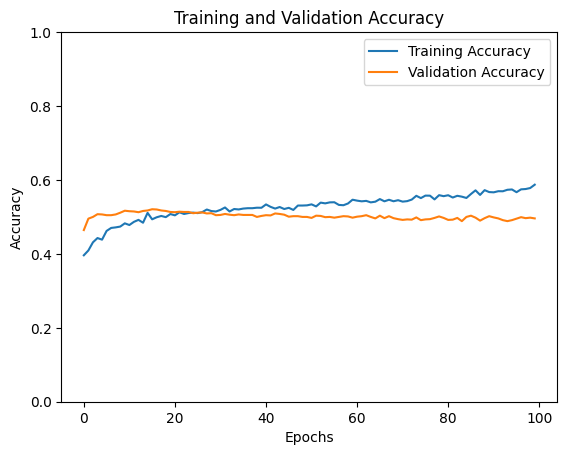

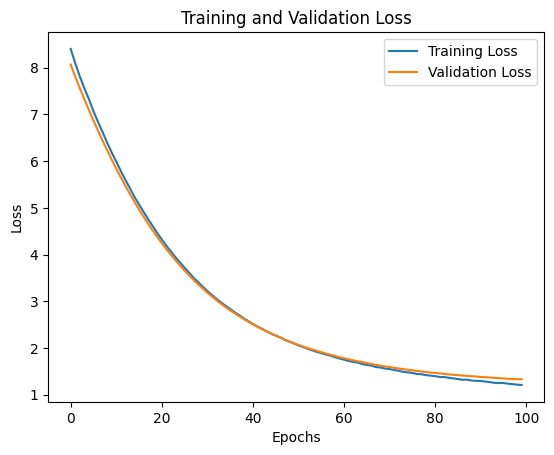

Test Accuracy: 0.50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Confusion Matrix:
[[317  59 195]
 [172  40 241]
 [202  56 580]]

Classification Report:
              precision    recall  f1-score   support

           0     0.4588    0.5552    0.5024       571
           1     0.2581    0.0883    0.1316       453
           2     0.5709    0.6921    0.6257       838

    accuracy                         0.5032      1862
   macro avg     0.4292    0.4452    0.4199      1862
weighted avg     0.4604    0.5032    0.4677      1862



In [20]:

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y.shape[1]),
    y=np.argmax(y, axis=1)
)
class_weights = dict(enumerate(class_weights))

def compute_dnn():
    # Define the DNN model
    model = Sequential([
        Dense(512, kernel_regularizer=l2(0.01)),  # Add L2 regularization
        BatchNormalization(),  # Batch Normalization
        LeakyReLU(alpha=0.1),  # Leaky ReLU activation
        Dropout(0.5),

        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Visualize training and validation log loss and accuracy
    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Visualize training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    import numpy as np
    from sklearn.metrics import confusion_matrix, classification_report

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Generate predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities and true labels into class indices
    y_pred_original = np.argmax(y_pred, axis=1)
    y_test_original = np.argmax(y_test, axis=1)

    # Display confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_original, y_pred_original))

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_original, digits=4))

compute_dnn()


#### K-Means


Classification Report:
              precision    recall  f1-score   support

        Away     0.3561    0.5247    0.4242       547
        Draw     0.2578    0.3579    0.2997       461
        Home     0.6611    0.3220    0.4331       854

    accuracy                         0.3904      1862
   macro avg     0.4250    0.4015    0.3857      1862
weighted avg     0.4716    0.3904    0.3975      1862

Visualizing Clusters...


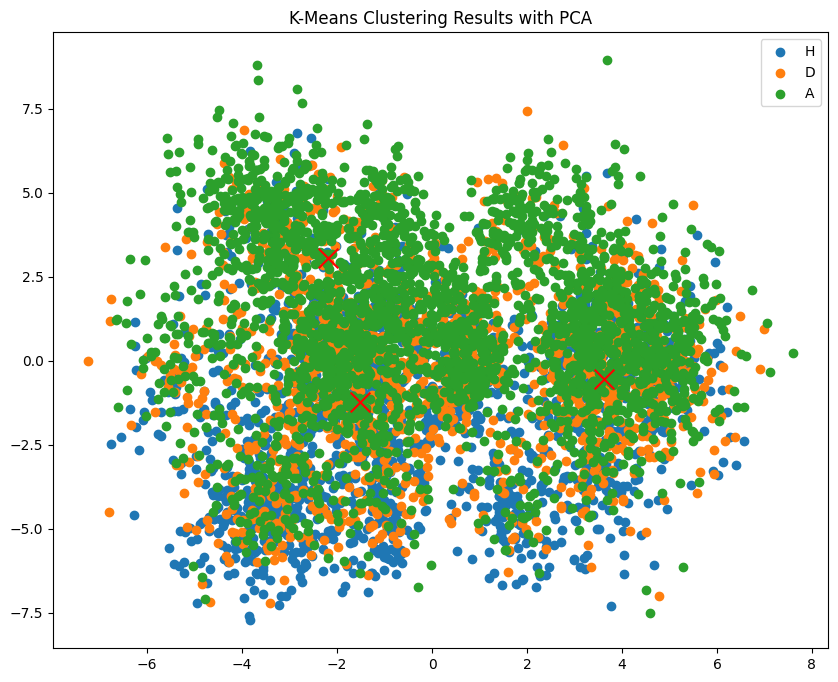

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Scatter Plot of the Clusters with PCA  
def plot_clusters(X, y_pred, kmeans):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    for cluster in np.unique(y_pred):
        cluster_points = X_pca[y_pred == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot centroids
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')

    plt.title("K-Means Clustering Results with PCA")
    
    plt.legend(["H", "D", "A"])
    plt.show()



# Evaluate Performance
def evaluate_performance(X, y_true, y_pred, kmeans):
    print("Visualizing Clusters...")
    plot_clusters(X, y_pred, kmeans)
    
def compute_knn():

    y_single = y.idxmax(axis=1).map({'FTR_A': 'Away', 'FTR_D': 'Draw', 'FTR_H': 'Home'})
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_single)


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )


    # Initialize K-Means with number of clusters equal to the number of unique classes
    n_clusters = len(le.classes_) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    cluster_labels = kmeans.labels_

    cont_matrix = confusion_matrix(y_train, cluster_labels)
    # Apply the Hungarian algorithm to find the optimal mapping
    row_ind, col_ind = linear_sum_assignment(-cont_matrix)
    cluster_to_label = {}
    for cluster, label in zip(col_ind, row_ind):
        cluster_to_label[cluster] = label


    test_cluster_labels = kmeans.predict(X_test)
    # Map cluster labels to actual labels using the optimal cluster_to_label mapping
    test_predicted_labels = pd.Series(test_cluster_labels).map(cluster_to_label)
    test_predicted_labels = test_predicted_labels.fillna(-1).astype(int)
    predicted_labels_original = np.empty_like(test_predicted_labels, dtype=object)

    # Identify valid predictions (clusters that were mapped)
    valid_indices = test_predicted_labels != -1

    # Inverse transform only valid predictions
    predicted_labels_original[valid_indices] = le.inverse_transform(test_predicted_labels[valid_indices])

    # Assign a placeholder for invalid predictions
    predicted_labels_original[~valid_indices] = "Unknown"

    # Inverse transform true labels for evaluation
    y_test_original = le.inverse_transform(y_test)

    print("\nClassification Report:")
    print(classification_report(
        y_test_original[valid_indices],
        predicted_labels_original[valid_indices],
        zero_division=0,
        digits=4
    ))

    evaluate_performance(X_train, y_test, y_train, kmeans)


compute_knn()

#### Support Vector Machine (SVM)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


def compute_svm():

    y_single = y.idxmax(axis=1).map({'FTR_A': 'Away', 'FTR_D': 'Draw', 'FTR_H': 'Home'})

    # Initialize LabelEncoder
    le = LabelEncoder()

    # Fit and transform the single labels
    y_encoded = le.fit_transform(y_single)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

    # Train SVM model
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, digits=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display performance
    print("Classification Report:\n", report)

compute_svm()


Classification Report:
               precision    recall  f1-score   support

        Away     0.5156    0.4597    0.4861       683
        Draw     0.3333    0.0468    0.0821       577
        Home     0.5372    0.8240    0.6504      1068

    accuracy                         0.5245      2328
   macro avg     0.4621    0.4435    0.4062      2328
weighted avg     0.4804    0.5245    0.4613      2328



### 5.2 Chosen Approach - Gradient Boosted Decision Tree

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Convert one-hot encoded labels to single integer labels
label_mapping = {'FTR_A': 0, 'FTR_D': 1, 'FTR_H': 2}

# Function to convert one-hot to single label
def one_hot_to_single(y):
    return y.idxmax(axis=1).map(label_mapping)

# Apply the function to y_train and y_test
y_train_single = one_hot_to_single(y_train)
y_test_single = one_hot_to_single(y_test)
y_val_single = one_hot_to_single(y_val)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Use 'balanced' strategy
    classes=np.unique(y_train_single),  # Unique class labels
    y=y_train_single  # Training target labels
)

# Map class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# Assign sample weights based on class weights
sample_weights = np.array([class_weight_dict[label] for label in y_train_single])

# Initialise model
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric=['mlogloss', 'merror'],
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    
    # Lower learning_rate means the model trains more slowly but can generalize better
    learning_rate=0.001,     
    
    # Increased n_estimators to compensate for the lower learning rate
    n_estimators=100,      
    
    # Reduce max_depth to reduce model complexity
    max_depth=4,           
    
    # Increase min_child_weight to require more samples at leaf nodes
    min_child_weight=5,    
    
    # Increase gamma if you want to further penalize splits
    gamma=0.5,             
    
    # Increase regularization to penalize large coefficients
    reg_alpha=2.0,
    reg_lambda=15.0,
    early_stopping=5,
    booster='dart',          # Enable dropout-based boosting
    sample_type='uniform',   # How to sample weights
    normalize_type='tree',   # How to normalize tree weight
    rate_drop=0.1,           # Dropout rate for trees
    skip_drop=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,   # further reduce the chance of overfitting
    colsample_bynode=0.8,
    grow_policy='lossguide',
    max_leaves=32,   
)

# Map your one-hot labels to single integer labels
label_mapping = {'FTR_A': 0, 'FTR_D': 1, 'FTR_H': 2}

def one_hot_to_single(y):
    return y.idxmax(axis=1).map(label_mapping)

y_train_single = one_hot_to_single(y_train)
y_val_single = one_hot_to_single(y_val)
y_test_single = one_hot_to_single(y_test)


# Train the classifier
xgb_clf.fit(
    X_train, 
    y_train_single,
    eval_set=[(X_train, y_train_single), (X_val, y_val_single)],
    verbose=True
)


Class weights: {0: 1.1517788089713843, 1: 1.3453026196928637, 2: 0.7202273002055374}
[0]	validation_0-mlogloss:1.09842	validation_0-merror:0.45946	validation_1-mlogloss:1.09845	validation_1-merror:0.49060
[1]	validation_0-mlogloss:1.09823	validation_0-merror:0.45745	validation_1-mlogloss:1.09830	validation_1-merror:0.49396
[2]	validation_0-mlogloss:1.09805	validation_0-merror:0.45577	validation_1-mlogloss:1.09815	validation_1-merror:0.48993
[3]	validation_0-mlogloss:1.09787	validation_0-merror:0.45509	validation_1-mlogloss:1.09800	validation_1-merror:0.49060
[4]	validation_0-mlogloss:1.09777	validation_0-merror:0.45627	validation_1-mlogloss:1.09793	validation_1-merror:0.49396


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "early_stopping", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-mlogloss:1.09768	validation_0-merror:0.45627	validation_1-mlogloss:1.09785	validation_1-merror:0.49262
[6]	validation_0-mlogloss:1.09762	validation_0-merror:0.45526	validation_1-mlogloss:1.09780	validation_1-merror:0.49262
[7]	validation_0-mlogloss:1.09744	validation_0-merror:0.45728	validation_1-mlogloss:1.09766	validation_1-merror:0.49128
[8]	validation_0-mlogloss:1.09738	validation_0-merror:0.45610	validation_1-mlogloss:1.09761	validation_1-merror:0.48993
[9]	validation_0-mlogloss:1.09719	validation_0-merror:0.45694	validation_1-mlogloss:1.09745	validation_1-merror:0.48859
[10]	validation_0-mlogloss:1.09710	validation_0-merror:0.45711	validation_1-mlogloss:1.09738	validation_1-merror:0.48792
[11]	validation_0-mlogloss:1.09692	validation_0-merror:0.45593	validation_1-mlogloss:1.09722	validation_1-merror:0.48725
[12]	validation_0-mlogloss:1.09687	validation_0-merror:0.45745	validation_1-mlogloss:1.09718	validation_1-merror:0.48591
[13]	validation_0-mlogloss:1.09684	va

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              device=None, early_stopping=5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=0.5, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=32, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, normalize_type='tree', ...)

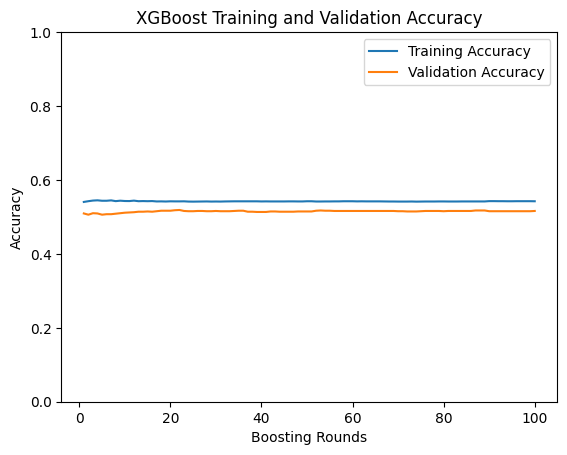

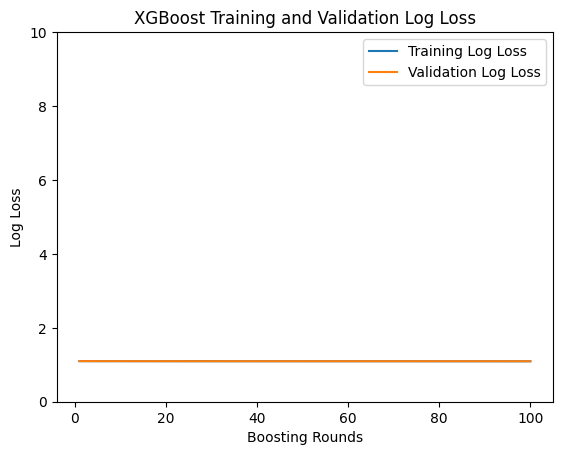

In [24]:
# Retrieve evaluation results
evals_result = xgb_clf.evals_result()

# Extract log loss for training and validation sets
train_logloss = evals_result['validation_0']['mlogloss']
val_logloss = evals_result['validation_1']['mlogloss']

# Extract error rates and convert to accuracy
train_merror = evals_result['validation_0']['merror']
val_merror = evals_result['validation_1']['merror']

train_accuracy = [1 - error for error in train_merror]
val_accuracy = [1 - error for error in val_merror]

# Determine the number of boosting rounds
num_rounds = len(train_logloss)

plt.plot(range(1, num_rounds + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_rounds + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(range(1, num_rounds + 1), train_logloss, label='Training Log Loss')
plt.plot(range(1, num_rounds + 1), val_logloss, label='Validation Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.ylim(0, 10)
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()
plt.show()

XGBoost Test Accuracy: 0.53

XGBoost Classification Report:
                  precision    recall  f1-score   support

FTR_A (Away Win)     0.5570    0.4361    0.4892       571
    FTR_D (Draw)     0.0000    0.0000    0.0000       453
FTR_H (Home Win)     0.5173    0.8735    0.6498       838

        accuracy                         0.5269      1862
       macro avg     0.3581    0.4365    0.3797      1862
    weighted avg     0.4036    0.5269    0.4425      1862


XGBoost Confusion Matrix:
[[249   0 322]
 [ 92   0 361]
 [106   0 732]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

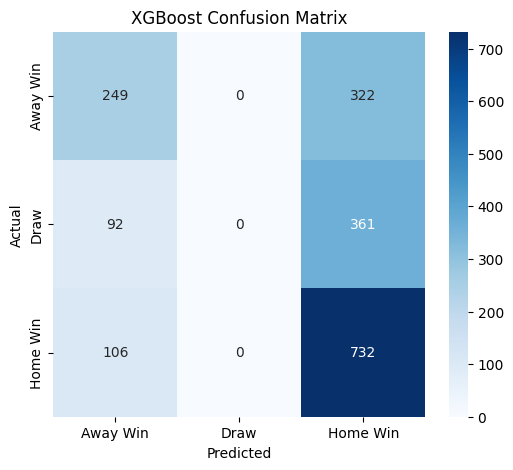

In [25]:
# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate test accuracy
test_accuracy_xgb = accuracy_score(y_test_single, y_pred_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")

# Generate classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test_single, y_pred_xgb, target_names=['FTR_A (Away Win)', 'FTR_D (Draw)', 'FTR_H (Home Win)'], digits=4))

# Generate confusion matrix
print("\nXGBoost Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_single, y_pred_xgb)
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

### 6. Results

### 7. Final Predictions on Test Set

In [26]:
# Step 1: Load and preprocess test data
epl_test = pd.read_csv('../data/epl-test.csv')

# Replace team names
epl_test['Date'] = epl_test['Date'].str.replace('Feb', '02', regex=False)
team_replacements = {
    'AFC Bournemouth': 'Bournemouth',
    'Spurs': 'Tottenham',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'Man Utd': 'Man United',
    'Nottingham Forest': 'Nott’m Forest'
}
epl_test['HomeTeam'] = epl_test['HomeTeam'].replace(team_replacements)
epl_test['AwayTeam'] = epl_test['AwayTeam'].replace(team_replacements)

loaded = load_and_prepare_data()

# Fix two-digit year and convert to datetime
epl_test['Date'] = epl_test['Date'].apply(lambda x: f"{x[:-2]}20{x[-2:]}")
epl_test['Date'] = pd.to_datetime(epl_test['Date'], format='%d-%m-%Y')

df_copy_2 = df.copy()

df_copy_2 = df_copy_2.drop(columns=['H14', 'A14',	'Attendance', 'HTV($m)', 'ATV($m)',	'HTPos_avg', 'ATPos_avg', 'HSPE (%)', 'HPE (%)', 'ASPE (%)', 'APE (%)'])

# Add missing columns to epl_test with default values
for col in df_copy_2.columns:
    if col not in epl_test.columns:
        epl_test[col] = np.nan

# Step 3: Combine training and test data
combined = pd.concat([df_copy_2, epl_test], ignore_index=True)

# Step 4: Recalculate 14-day density for all data
combined = calculate_14_day_density(combined, loaded)

# Step 5: Calculate other features on test data
combined = calculate_standings(combined)
combined = compute_team_features(combined)

# Step 6: Final adjustments (alterations and formatting)
alterations = {
    'Manchester City': 'Man City',
    'Arsenal FC': 'Arsenal',
    'Chelsea FC': 'Chelsea',
    'Liverpool FC': 'Liverpool',
    'Manchester United': 'Man United',
    'Tottenham Hotspur': 'Tottenham',
    'Newcastle United': 'Newcastle',
    'Brighton & Hove Albion': 'Brighton',
    'West Ham United': 'West Ham',
    'Nottingham Forest': "Nott'm Forest",
    'Brentford FC': 'Brentford',
    'Wolverhampton Wanderers': 'Wolves',
    'AFC Bournemouth': 'Bournemouth',
    'Everton FC': 'Everton',
    'Fulham FC': 'Fulham',
    'Southampton FC': 'Southampton',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'West Bromwich Albion': 'West Brom',
    'Queens Park Rangers': 'QPR',
    'Hull City': 'Hull',
    'Stoke City': 'Stoke',
    'Swansea City': 'Swansea',
    'Manchester Utd': 'Man United',
    'Newcastle Utd': 'Newcastle',
    "Nott'ham Forest": "Nott'm Forest",
    "Luton Town": "Luton",
    'Sheffield Utd': 'Sheffield United',
    'Leeds United': 'Leeds',
    'Norwich City': 'Norwich',
    'Cardiff City': 'Cardiff',
    'Birmingham City': 'Birmingham',
    'Blackburn Rovers': 'Blackburn',
    'Blackpool FC': 'Blackpool',
    'Bolton Wanderers': 'Bolton',
    'Bradford City': 'Bradford',
    'Burnley FC': 'Burnley',
    'Charlton Athletic': 'Charlton',
    'Coventry City': 'Coventry',
    'Derby County': 'Derby',
    'Huddersfield Town': 'Huddersfield',
    'Middlesbrough FC': 'Middlesbrough',
    'Portsmouth FC': 'Portsmouth',
    'Reading FC': 'Reading',
    'Sunderland AFC': 'Sunderland',
    'Watford FC': 'Watford',
    'Wigan Athletic': 'Wigan'
}
combined = main_workflow(combined, alterations)

# Format 'Date' column
combined['Date'] = combined['Date'].dt.strftime('%d/%m/%Y')


/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/748822897.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epl_test[col] = np.nan
/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/748822897.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epl_test[col] = np.nan
/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_57601/748822897.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [27]:
combined.to_csv('../data/epl-test-processed.csv', index=False)

In [28]:
# Extract the last 10 rows of the combined DataFrame
epl_test = combined.tail(10)

# Optional: Reset the index of epl_test if needed
epl_test = epl_test.reset_index(drop=True)

# View epl_test
epl_test

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,H14,A14,Attendance,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,NaN,NaN,NaN,NaN,01/02/2025,Bournemouth,Liverpool,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liverpool,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948
1,NaN,NaN,NaN,NaN,01/02/2025,Arsenal,Man City,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Man City,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042
2,NaN,NaN,NaN,NaN,01/02/2025,Brentford,Tottenham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham,2024,20,6,16,1.263158,1.632653,1.4661

In [29]:
# Drop specified columns and columns starting with 'HomeTeam' or 'AwayTeam'
columns_to_drop = ['Day', 'Month', 'Year', 'DayOfWeek']
columns_to_drop += [col for col in combined.columns if col.startswith('HomeTeam_') or col.startswith('AwayTeam_')]

# Drop the columns from the DataFrame
epl_test = epl_test.drop(columns=columns_to_drop, errors='ignore')

# Preview the updated DataFrame
epl_test


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,Attendance,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,01/02/2025,Bournemouth,Liverpool,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liverpool,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948
1,01/02/2025,Arsenal,Man City,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Man City,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042
2,01/02/2025,Brentford,Tottenham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250
3,01/02/2025,Chelsea,West Ham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Ham,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846
4,01/02/2025,Everton,Leicester,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leicester,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352
5,01/02/2025,Ipswich,Southampton,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southampton,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250
6,01/02/2025,Man United,Crystal Palace,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Crystal Palace,2024,20,16,10,1.992481,1.160000,1.823845,1.147368,0.976369,1.429474,1.9,1.5,6.0,1.0,0,0,0.320000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,854.15,438.00,0.522,0.456,1.393106,0.382166,3.676202,1.663546
7,01/02/2025,Newcastle,Fulham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fulham,2024,20,12,2,1.328655,1.154887,1.319298,1.156391,1.422222,1.458647,1.3,0.8,1.0,-4.0,1,0,0.242424,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,657.65,346.00,0.490,0.535,-0.911943,0.037179,-2.602312,-0.318589
8,01/02/2025,Nott’m Forest,Brighton,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brighton,2024,20,0,11,0.000000,1.214035,0.000000,1.214035,0.000000,1.407018,0.0,1.7,0.0,8.0,0,3,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,574.60,NaN,0.538,NaN,NaN,-0.289175,-1.860250
9,01/02/2025,Wolves,Aston Villa,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aston Vil

In [30]:
# Create dummies without removing the original columns
dummies = pd.get_dummies(
    epl_test[['FTR', 'HomeTeam', 'AwayTeam']],
    prefix=['FTR', 'HomeTeam', 'AwayTeam']
)

# Concatenate the dummies with the original DataFrame
epl_test = pd.concat([epl_test, dummies], axis=1)

# Preview the resulting DataFrame
epl_test


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,Attendance,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),FTR_A,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Chelsea,HomeTeam_Everton,HomeTeam_Ipswich,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Nott’m Forest,HomeTeam_Wolves,AwayTeam_Aston Villa,AwayTeam_Brighton,AwayTeam_Crystal Palace,AwayTeam_Fulham,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham
0,01/02/2025,Bournemouth,Liverpool,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liverpool,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,01/02/2025,Arsenal,Man City,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Man City,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,01/02/2025,Brentford,Tottenham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,01/02/2025,Chelsea,West Ham,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Ham,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,01/02/2025,Everton,Leicester,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leicester,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,01/02/2025,Ipswich,Southampton,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southampton,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,01/02/2025,Man United,Crystal Palace,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [31]:
epl_test_copy = epl_test.copy()

epl_test_copy = epl_test_copy.drop(columns=['Winner', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'])

epl_test_copy


,Date,HomeTeam,AwayTeam,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,Attendance,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),FTR_A,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Chelsea,HomeTeam_Everton,HomeTeam_Ipswich,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Nott’m Forest,HomeTeam_Wolves,AwayTeam_Aston Villa,AwayTeam_Brighton,AwayTeam_Crystal Palace,AwayTeam_Fulham,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham
0,01/02/2025,Bournemouth,Liverpool,NaN,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,01/02/2025,Arsenal,Man City,NaN,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,01/02/2025,Brentford,Tottenham,NaN,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,01/02/2025,Chelsea,West Ham,NaN,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,01/02/2025,Everton,Leicester,NaN,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,01/02/2025,Ipswich,Southampton,NaN,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,01/02/2025,Man United,Crystal Palace,NaN,2024,20,16,10,1.992481,1.160000,1.823845,1.147368,0.976369,1.429474,1.9,1.5,6.0,1.0,0,0,0.320000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,854.15,438.00,0.522,0.456,1.393106,0.382166,3.676202,1.663546,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
7,01/02/2025,Newcastle,Fulham,NaN,2024,20,12,2,1.328655,1.154887,1.319298,1.156391,1.422222,1.458647,1.3,0.8,1.0,-4.0,1,0,0.242424,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,657.65,346.00,0.490,0.535,-0.911943,0.0371

In [32]:
epl_test_copy = process_date_columns(epl_test_copy)

epl_test_copy


,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,Attendance,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),FTR_A,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Chelsea,HomeTeam_Everton,HomeTeam_Ipswich,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Nott’m Forest,HomeTeam_Wolves,AwayTeam_Aston Villa,AwayTeam_Brighton,AwayTeam_Crystal Palace,AwayTeam_Fulham,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham
0,1,2,2025,6,2025-02-01,Bournemouth,Liverpool,NaN,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,1,2,2025,6,2025-02-01,Arsenal,Man City,NaN,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,1,2,2025,6,2025-02-01,Brentford,Tottenham,NaN,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,1,2,2025,6,2025-02-01,Chelsea,West Ham,NaN,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,2,2025,6,2025-02-01,Everton,Leicester,NaN,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,1,2,2025,6,2025-02-01,Ipswich,Southampton,NaN,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,1,2,2025,6,2025-02-01,Man United,Crystal Palace,NaN,2024,20,16,10,1.992481,1.160000,1.823845,1.147368,0.976369,1.429474,1.9,1.5,6.0,1.0,0,0,0.320000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,854.15,438.00,0.522,0.456,1.393106,0.382166,3.676202,1.663546,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
7,1,2,2025,6,2025-02-01,Newcastle,Fulham,NaN,2024,20,12,2,1.328655,1.154887,1.319298,1.156391,1.422222,1.458647,1.3,0.8,1.0,-4.0,1,0,0.242424,0.090909,N

In [33]:
epl_test_copy.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'Attendance'], inplace=True)

epl_test_copy

,Day,Month,Year,DayOfWeek,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),FTR_A,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Chelsea,HomeTeam_Everton,HomeTeam_Ipswich,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Nott’m Forest,HomeTeam_Wolves,AwayTeam_Aston Villa,AwayTeam_Brighton,AwayTeam_Crystal Palace,AwayTeam_Fulham,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham
0,1,2,2025,6,NaN,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,1,2,2025,6,NaN,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,1,2,2025,6,NaN,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,1,2,2025,6,NaN,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,2,2025,6,NaN,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,1,2,2025,6,NaN,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,1,2,2025,6,NaN,2024,20,16,10,1.992481,1.160000,1.823845,1.147368,0.976369,1.429474,1.9,1.5,6.0,1.0,0,0,0.320000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,854.15,438.00,0.522,0.456,1.393106,0.382166,3.676202,1.663546,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
7,1,2,2025,6,NaN,2024,20,12,2,1.328655,1.154887,1.319298,1.156391,1.422222,1.458647,1.3,0.8,1.0,-4.0,1,0,0.242424,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,657.65,346.00,0.490,0.535,-0.911943,0.037179,-2.602312,-0.318589,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
8,1,2,2025,6,NaN,2024,20,0,11,0.000000,1.214035,0.00

In [34]:
import numpy as np

# Step 1: Load and preprocess test data
epl_test = pd.read_csv('../data/epl-test.csv')

# Add missing columns to epl_test_copy and fill them with NaN
for col in training_features:
    if col not in epl_test_copy.columns:
        epl_test_copy[col] = 0

# Align epl_test_copy to the training features
X_test = epl_test_copy[training_features]

# Use the trained model to predict outcomes
predictions = xgb_clf.predict(X_test)

# Map predictions to their corresponding match results
outcome_map = {0: 'A', 1: 'D', 2: 'H'}
epl_test_copy['Predicted_FTR'] = [outcome_map[pred] for pred in predictions]

# Concatenate the relevant columns from epl_test and epl_test_copy
result = pd.concat(
    [epl_test[['Date', 'HomeTeam', 'AwayTeam']], epl_test_copy[['Predicted_FTR']]], 
    axis=1
)

# Output the results
print("Predictions for test matches:")
print(result)


Predictions for test matches:
        Date           HomeTeam        AwayTeam Predicted_FTR
0  01-Feb-25    AFC Bournemouth       Liverpool             H
1  01-Feb-25            Arsenal        Man City             H
2  01-Feb-25          Brentford           Spurs             H
3  01-Feb-25            Chelsea        West Ham             H
4  01-Feb-25            Everton  Leicester City             H
5  01-Feb-25       Ipswich Town     Southampton             H
6  01-Feb-25            Man Utd  Crystal Palace             H
7  01-Feb-25          Newcastle          Fulham             H
8  01-Feb-25  Nottingham Forest        Brighton             A
9  01-Feb-25             Wolves     Aston Villa             H
